In [1]:
#importing libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rand
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import words, stopwords, wordnet
import nltk
import contractions
from nltk.stem import WordNetLemmatizer, porter
from textblob import TextBlob
from tqdm import tqdm
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from tensorflow.keras.optimizers import Adam

In [2]:
#to disable TF 2.x behaviour
tf.compat.v1.disable_v2_behavior()

#enables eager execution
tf.compat.v1.enable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#dropping id and index: no requirement
#dropping annotations col because we just want to classify if tweet is toxic or not

df = pd.read_csv("C:/Users/user8/Downloads/MGP Resources/twitter_parsed_dataset.csv").drop(columns=['id', 'index', "Annotation"])
df.columns = ['text', 'label']
df.sample(10)

,text,label
3605,@ItsOnlyAkram @steveplrose This is #Islamophob...,0.0
4757,RT @Celebchaser: I'm certain Pete has a spitto...,0.0
10782,#mkr THIS TIME IM READY TO RUN,0.0
2565,@Popehat @SatoshiKsutra @DarkTechMonitor frank...,0.0
3219,@Animecommentary no worries.,0.0
16700,RT @SimonLeong: The only thing that seems to b...,0.0
13237,"RT @ElliottVKay Call me sexist, but I'm just n...",1.0
10395,Kat might as well go home now since she has no...,1.0
14587,"Sipping coffee, pulling down follower list, ru...",0.0
6692,@Vandaliser @sajid_fairooz @IsraeliRegime Algo...,0.0


In [4]:
# printing 10 random sample texts for understanding scenario

for i in range(0,10):
    print(df['text'][(rand.randint(0,16851))],'\n')

#MKR time. Have a feeling that the remote may go through the TV over the next hour with these two clowns. 

FFS last year WA had Chloe &amp; Kelly and now we have Kat &amp; Andre. Channel 7 doesn't like Perth haha! #mkr 

RT @sudixitca: Greece is like a patient in the ICU who doesn't want to pay for the meds and hospital stay. #EUWelfareScheme 

RT @LisaGinNZ: Charlie Hebdo attacks prove critics were right about Islam http://t.co/EnE8KqwxmX via @tennessean 

@anniekfox Can you give an example? 

RT @AnitaIngle: ~Remember #JohnCantile video:Beautiful Mosul under ISIS 2 wks ago? Well here's #Raqqa under #IS today=Real life w/ IS http:… 

@a_man_in_black i took a bunch of screencaps of the harassment the conf i was speaking at received from them. that's going to be fun. 

RT @Madasatrain69: @OZzSue @Muslim_Patrol @sneekinsneekout
Read an Islamist's tweet. http://t.co/7uAkhcWAvl
Insane.
Life denying. Heartless… 

RT @PollyMaeve: Fucking Kat and Andre. Eew. #MKR 

@StrangerOnFire @Raqqa_Sl 

Text(0.5, 1.0, 'Toxicity vs Frequency')

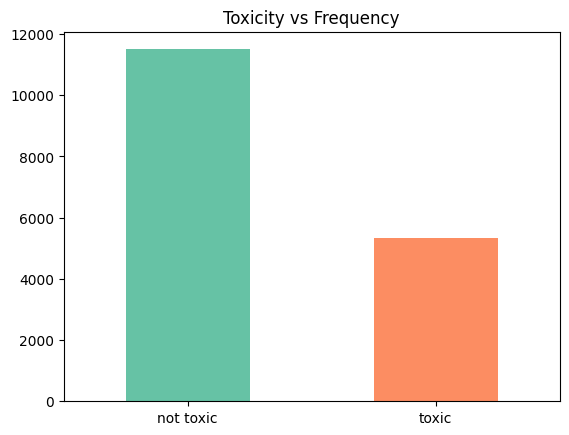

In [5]:
df['label'].value_counts().plot(kind='bar', color=sns.color_palette("Set2", 15))
plt.xticks([0,1],['not toxic', 'toxic'], rotation=0)
plt.title("Toxicity vs Frequency")

In [6]:
def clean_text(sample):
    
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('\{.*?\}', '', sample) #text between {curly brackets}
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = re.sub(' u ', ' you ', sample) #replace u with you
    sample = re.sub(' o ', ' you ', sample) #replace o with space
    sample = re.sub(' r ', ' are ', sample) #replace r with are
    sample = re.sub(' hv ', ' have ', sample) #replace hv with have
    sample = re.sub(' s ', ' ', sample) #replace s with space
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = sample.strip()
    sample = ' '.join([x.strip()  for x in sample.split()])
    
    return sample

In [7]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))
df

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


In [8]:
for i in range(0,10):
    print(df['cleaned_text'][(rand.randint(0,16851))],'\n')

rt onlythetruthnow islam is not a religion this is what an honest ex muslim woman victim of islam says 

yup something is happening not sure what 

and you can only get highly educated people out of a free modern society not a h century one based on superstition 

people have ask that dumb question times the answer is that there is no good side fighting for aleppo 

 

people need to stop with the breaking about al asad the information is already both old and wrong everything is fine at al asad 

when people leave islam they do not announce it they just quietly walk away 

women referees suck man and no i am not sexist but damn bruh that was not a good call 

i know putin that is a fact read masha gessen s book the man without a face 

now the daesh must either reinforce kobane or loose it so the coalition must protect the roads into kobane against reinforcement 



In [9]:
df['correct_text'] = np.nan
df

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,NaN
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,NaN
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,NaN
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,NaN
4,#mkr No No No No No No,0.0,mkr no no no no no no,NaN
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,NaN
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,NaN
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,NaN
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,NaN


In [10]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = porter.PorterStemmer()

def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(sample, lemma=False, spell=False):
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [11]:
count = 0
for text in tqdm(df['cleaned_text']):
    df['correct_text'][count] = correct_text(text, lemma=True)
    count += 1

  0%|                                                                                        | 0/16851 [00:00<?, ?it/s]C:\Users\user8\AppData\Local\Temp\ipykernel_2108\4273514287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct_text'][count] = correct_text(text, lemma=True)
100%|███████████████████████████████████████████████████████████████████████████| 16851/16851 [00:53<00:00, 315.88it/s]


In [12]:
df['char_count'] = df['correct_text'].str.len() #includes spaces
df

,text,label,cleaned_text,correct_text,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,82
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...,50
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly,47
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,3
...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,42
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,50
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,93
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,17


<AxesSubplot: >

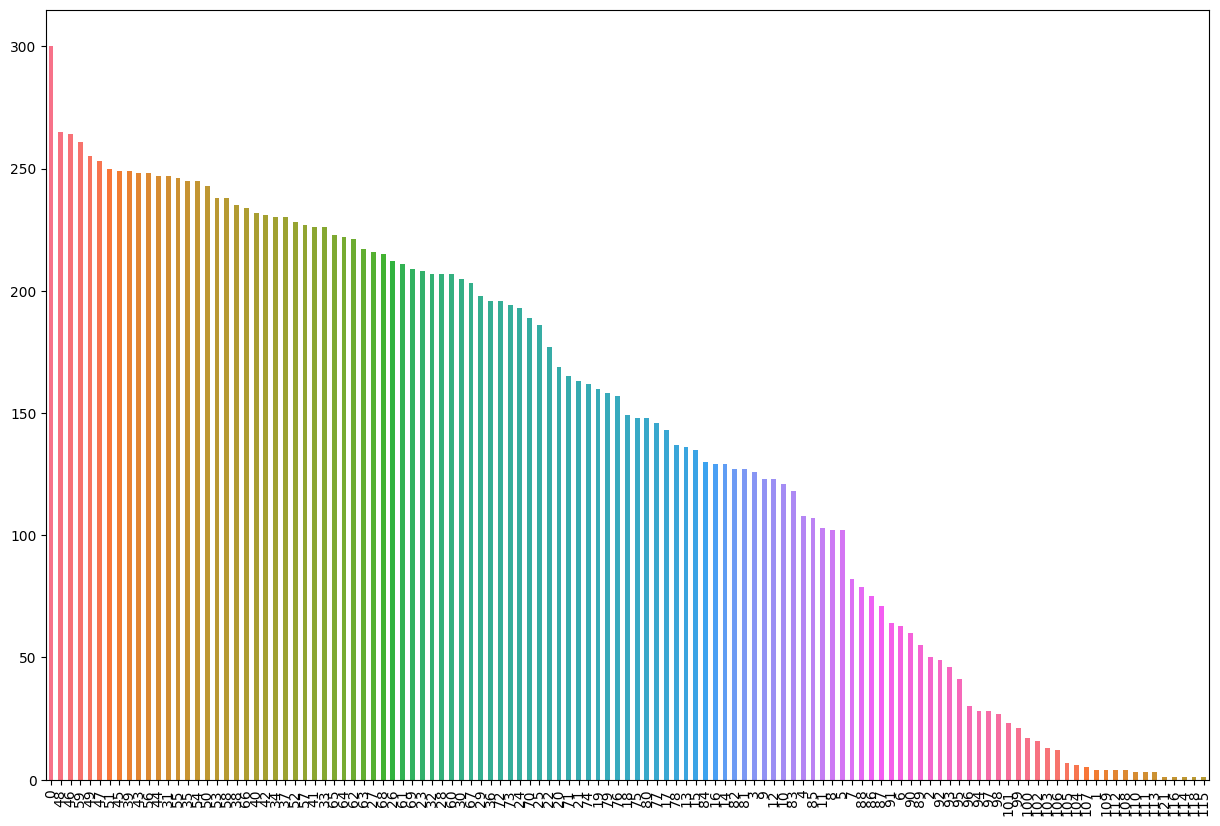

In [13]:
plt.figure(figsize=(15,10))
df['char_count'].value_counts().plot(kind='bar', color=sns.color_palette("husl", 100))

In [14]:
df = df[(df['char_count'] != 0)].reset_index(drop=True)
df[(df['label'] == 0)]

,text,label,cleaned_text,correct_text,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,read context change meaning history islamic sl...,51
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,idiot claim people try stop become terrorist m...,82
4,#mkr No No No No No No,0.0,mkr no no no no no no,mkr,3
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0,rt saudi preacher who raped and tortured his f...,rt saudi preacher rap torture five year old da...,66
7,Going to make some pancakes.....Don't hve any ...,0.0,going to make some pancakes do not hve any str...,go make pancake hve strawberry hve banana mkr,45
...,...,...,...,...,...
16546,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,feel sorry girl safe kat andre go home mkr,42
16547,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,mkr pretty good dish happy ok well never eat p...,50
16548,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,rt deconstruct lemon tart please go one season...,93
16549,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,stupid talk block,17


In [15]:
df[(df['label'] == 1)]

,text,label,cleaned_text,correct_text,char_count
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,rt call sexist go auto place would rather talk...,50
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,wrong isi follow example mohammed quran exactly,47
6,RT @Millhouse66 @Maureen_JS nooo not sexist bu...,1.0,rt nooo not sexist but most women are bad drivers,rt nooo sexist woman bad driver,31
9,RT @Newmanzaa: There's something wrong when a ...,1.0,rt there is something wrong when a girl wins w...,rt something wrong girl win wayne rooney stree...,65
11,@SirajZarook @OdiniaInvictus @BilalIGhumman @I...,1.0,a good muslim is good despite his bad religion...,good muslim good despite bad religion,37
...,...,...,...,...,...
16532,RT @DarylMansbridge Just don't find Woman come...,1.0,rt just do not find woman comedians funny in t...,rt find woman comedian funny slightest notsexist,48
16534,RT @Lord_Marx I'm not sexist but I hate all fe...,1.0,rt i am not sexist but i hate all female rappers,rt sexist hate female rapper,28
16536,"@sibelo76 Yes, all that Islam is making ISIS s...",1.0,yes all that islam is making isis so loving idiot,yes islam make isi love idiot,29
16541,yeah so annoying how they're doing their jobs ...,1.0,yeah so annoying how they are doing their jobs...,yeah annoy job call sexist woman football comm...,75


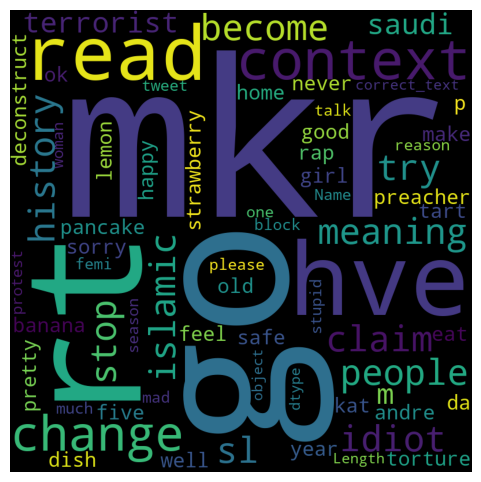

In [16]:
g = str(df[df['label']== 0]['correct_text'])

wc = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
  
plt.show()

In [17]:
for i in range(0,16000):
    if(str(df['correct_text'][i]).count(' hve ') != 0):
        print(i, df['correct_text'][i])

7 go make pancake hve strawberry hve banana mkr


In [18]:
df['correct_text'][7] = re.sub(' hve ', ' have ', df['correct_text'][7]) #replace hve with have
print(df['correct_text'][7])

go make pancake have strawberry have banana mkr


C:\Users\user8\AppData\Local\Temp\ipykernel_2108\4208531905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct_text'][7] = re.sub(' hve ', ' have ', df['correct_text'][7]) #replace hve with have


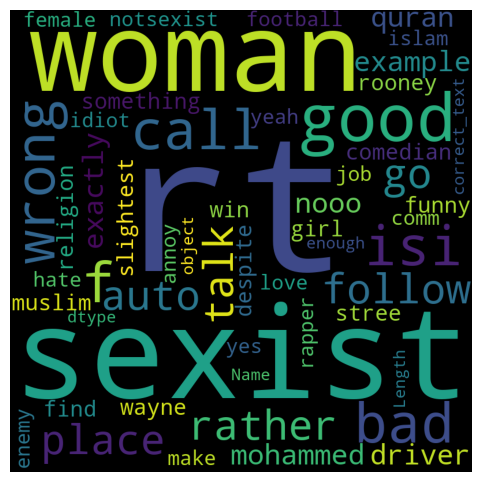

In [19]:
g = str(df[df['label']==1]['correct_text'])

wc = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
  
plt.show()

In [20]:
final_df = df.drop(columns=['text', 'cleaned_text', 'char_count'])
final_df.to_csv("C:/Users/user8/Downloads/MGP Resources/Project 10/data/cleaned_twitter_dataset.csv")
final_df

,label,correct_text
0,0.0,read context change meaning history islamic sl...
1,0.0,idiot claim people try stop become terrorist m...
2,1.0,rt call sexist go auto place would rather talk...
3,1.0,wrong isi follow example mohammed quran exactly
4,0.0,mkr
...,...,...
16546,0.0,feel sorry girl safe kat andre go home mkr
16547,0.0,mkr pretty good dish happy ok well never eat p...
16548,0.0,rt deconstruct lemon tart please go one season...
16549,0.0,stupid talk block


In [21]:
vocab = Counter()
for text in final_df['correct_text']:
    tokens = [word for word in text.split()]
    vocab.update(tokens)
    
print(vocab.most_common(50))

[('mkr', 4941), ('rt', 3683), ('woman', 1236), ('kat', 1104), ('sexist', 1095), ('get', 1064), ('like', 1043), ('go', 991), ('islam', 926), ('muslim', 793), ('would', 747), ('people', 742), ('make', 707), ('amp', 691), ('one', 670), ('say', 626), ('think', 618), ('girl', 595), ('cannot', 555), ('know', 554), ('andre', 548), ('want', 526), ('see', 517), ('time', 482), ('isi', 481), ('look', 466), ('well', 453), ('call', 446), ('fuck', 428), ('really', 400), ('good', 398), ('men', 383), ('need', 379), ('thing', 372), ('right', 360), ('even', 322), ('oh', 305), ('way', 303), ('give', 303), ('u', 303), ('take', 303), ('talk', 300), ('female', 294), ('never', 291), ('bad', 290), ('use', 287), ('try', 285), ('year', 285), ('hate', 281), ('show', 278)]


In [22]:
final_df['correct_text'] = final_df['correct_text'].apply(lambda x: clean_text(str(x)))
final_df

,label,correct_text
0,0.0,read context change meaning history islamic sl...
1,0.0,idiot claim people try stop become terrorist m...
2,1.0,rt call sexist go auto place would rather talk...
3,1.0,wrong isi follow example mohammed quran exactly
4,0.0,mkr
...,...,...
16546,0.0,feel sorry girl safe kat andre go home mkr
16547,0.0,mkr pretty good dish happy ok well never eat p...
16548,0.0,rt deconstruct lemon tart please go one season...
16549,0.0,stupid talk block


In [23]:
for i in range(0,16000):
    if(str(final_df['correct_text'][i]).count(' u ') != 0):
        print(i, final_df['correct_text'][i])

In [24]:
vocab = Counter()
for text in final_df['correct_text']:
    tokens = [word for word in text.split()]
    vocab.update(tokens)
    
print(vocab.most_common(50))

[('mkr', 4941), ('rt', 3683), ('woman', 1236), ('kat', 1104), ('sexist', 1095), ('get', 1064), ('like', 1043), ('go', 991), ('islam', 926), ('muslim', 793), ('would', 747), ('people', 742), ('make', 707), ('amp', 691), ('one', 670), ('say', 626), ('think', 618), ('girl', 595), ('cannot', 555), ('know', 554), ('andre', 548), ('want', 526), ('see', 517), ('time', 482), ('isi', 481), ('look', 466), ('well', 453), ('call', 446), ('fuck', 428), ('really', 400), ('good', 398), ('men', 383), ('need', 379), ('thing', 372), ('right', 360), ('even', 322), ('you', 306), ('oh', 305), ('way', 303), ('give', 303), ('take', 303), ('talk', 300), ('female', 294), ('never', 291), ('bad', 290), ('use', 287), ('try', 285), ('year', 285), ('hate', 281), ('show', 278)]


In [25]:
lines = [a for a in vocab.keys()]
data = '\n'.join(lines)
file = open("C:/Users/user8/Downloads/MGP Resources/Project 10/data/vocab.txt", 'w', encoding="utf-8")
file.write(data)
file.close()

In [26]:
def tokenize(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

#  define the model
def define_model(vocab_size, max_length, n_words):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(Flatten(input_shape=(n_words,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(0.0001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [27]:
X = final_df['correct_text']
y = final_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [28]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [29]:
vocab_set = set([x for x in vocab if len(x)>2])

tokenizer = tokenize(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [30]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [31]:
clf_model = define_model(vocab_size, max_length, x_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1110300   
                                                                 
 flatten (Flatten)           (None, 2300)              0         
                                                                 
 dense (Dense)               (None, 50)                115050    
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,225,401
Trainable params: 1,225,401
Non-trainable params: 0
_________________________________________________________________


In [44]:
type(y_train)

pandas.core.series.Series

In [45]:
y_train

4915     0.0
7370     0.0
1478     0.0
15312    1.0
10012    0.0
        ... 
6765     0.0
4023     0.0
7259     0.0
3775     1.0
10137    0.0
Name: label, Length: 12413, dtype: float64

In [32]:
clf_model.fit(x_train, y_train.values, epochs=50, verbose=2, batch_size=74)

Epoch 1/50
168/168 - 2s - loss: 0.6234 - accuracy: 0.6757 - 2s/epoch - 14ms/step
Epoch 2/50
168/168 - 2s - loss: 0.5742 - accuracy: 0.7042 - 2s/epoch - 12ms/step
Epoch 3/50
168/168 - 2s - loss: 0.4971 - accuracy: 0.7851 - 2s/epoch - 11ms/step
Epoch 4/50
168/168 - 2s - loss: 0.4138 - accuracy: 0.8248 - 2s/epoch - 11ms/step
Epoch 5/50
168/168 - 2s - loss: 0.3523 - accuracy: 0.8548 - 2s/epoch - 11ms/step
Epoch 6/50
168/168 - 2s - loss: 0.3056 - accuracy: 0.8771 - 2s/epoch - 11ms/step
Epoch 7/50
168/168 - 2s - loss: 0.2668 - accuracy: 0.8974 - 2s/epoch - 11ms/step
Epoch 8/50
168/168 - 2s - loss: 0.2321 - accuracy: 0.9152 - 2s/epoch - 11ms/step
Epoch 9/50
168/168 - 2s - loss: 0.2016 - accuracy: 0.9288 - 2s/epoch - 11ms/step
Epoch 10/50
168/168 - 2s - loss: 0.1745 - accuracy: 0.9428 - 2s/epoch - 11ms/step
Epoch 11/50
168/168 - 2s - loss: 0.1508 - accuracy: 0.9526 - 2s/epoch - 11ms/step
Epoch 12/50
168/168 - 2s - loss: 0.1305 - accuracy: 0.9606 - 2s/epoch - 12ms/step
Epoch 13/50
168/168 - 2s 

In [33]:
clf_model.evaluate(x_train, y_train, verbose=1)[1]

388/388 [==============================] - 1s 1ms/step - loss: 0.0071 - accuracy: 0.9975


0.9975026249885559

In [34]:
clf_model.evaluate(x_test, y_test, verbose=1)[1]

130/130 [==============================] - 0s 1ms/step - loss: 1.0465 - accuracy: 0.7881


0.7880618572235107

In [35]:
clf_model.predict(x_test[0].reshape(1,-1))[0,0]

1/1 [==============================] - 0s 86ms/step


0.9999854

In [36]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=clf_model):
    line = text
    # clean review
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
#     print(yhat)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    return percent_pos
#     if round(percent_pos) == 0:
#         return (1-percent_pos), 'NEGATIVE'
#     return percent_pos, 'POSITIVE'


In [37]:
predict_sentiment(final_df['correct_text'][200], vocab_set, tokenizer, max_length, clf_model)

4.0400073e-06

In [38]:
final_df['correct_text'][200]

'rt leak tape president erdogan told son bilal dispose million cash v'

In [39]:
predict_sentiment('you are such a good person nicest person i have ever seen', vocab_set, tokenizer, max_length, clf_model)

2.6328626e-05

In [40]:
predict_sentiment('trump is a bastard just kill him already', vocab_set, tokenizer, max_length, clf_model)

0.0009568065

In [41]:
predict_sentiment('biden is a bastard just kill him already', vocab_set, tokenizer, max_length, clf_model)

0.00010705036

In [42]:
predict_sentiment('the best person on earth is you the reader', vocab_set, tokenizer, max_length, clf_model)

9.280494e-05

In [43]:
clf_model.save("C:/Users/user8/Downloads/MGP Resources/Project 10/models/clf_seq.h5")